# Proyecto Final: 
### Reconocimiento de emociones con visión por computadora

### Preparación dataset

#### Preparación

In [24]:
# Importar librerías y establecer las rutas de los archivos

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import keras
import matplotlib.pyplot as plt
import numpy as np

train_dir = 'C:/Users/jmino/OneDrive/Escritorio/archive/images/images/train'
validation_dir = 'C:/Users/jmino/OneDrive/Escritorio/archive/images/images/validation'

#### Cargar imagenes

In [20]:
# Definir ImageDataGenerator para la augmentación y normalización de datos en el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1.0/255,         # Escala los valores de los píxeles a un rango de 0 a 1
    rotation_range=40,       # Rango de rotación aleatoria en grados (aumentado a 40)
    width_shift_range=0.3,   # Rango de desplazamiento horizontal aleatorio como una fracción del ancho total (aumentado a 0.3)
    height_shift_range=0.3,  # Rango de desplazamiento vertical aleatorio como una fracción de la altura total (aumentado a 0.3)
    shear_range=0.3,         # Rango de transformación de corte (aumentado a 0.3)
    zoom_range=0.3,          # Rango de zoom aleatorio (aumentado a 0.3)
    horizontal_flip=True,    # Voltea las imágenes horizontalmente de forma aleatoria
    fill_mode='nearest'      # Estrategia de relleno para los nuevos píxeles que se crean al aplicar las transformaciones
)

# Definir ImageDataGenerator para la normalización de datos en el conjunto de validación
validation_datagen = ImageDataGenerator(rescale=1.0/255)  # Solo escala los valores de los píxeles a un rango de 0 a 1

# Cargar y preprocesar el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # Ajusta el tamaño de las imágenes a 64x64 píxeles (puede ajustarse según sea necesario)
    batch_size=32,              # Tamaño del lote
    class_mode='categorical',  # Modo de clasificación: las etiquetas son categóricas
    color_mode='grayscale' # Modo de color: imágenes en escala de grises
)

# Cargar y preprocesar el conjunto de validación
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(48, 48),  # Ajusta el tamaño de las imágenes a 64x64 píxeles (puede ajustarse según sea necesario)
    batch_size=32,         # Tamaño del lote
    class_mode='categorical',  # Modo de clasificación: las etiquetas son categóricas
    color_mode='grayscale'  # Modo de color: imágenes en escala de grises
)

# Nota: Las imágenes de entrenamiento y validación tienen aproximadamente 2 KB, por lo que tienen una baja resolución.
# Es importante tener en cuenta que la baja resolución puede afectar la precisión del modelo.


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


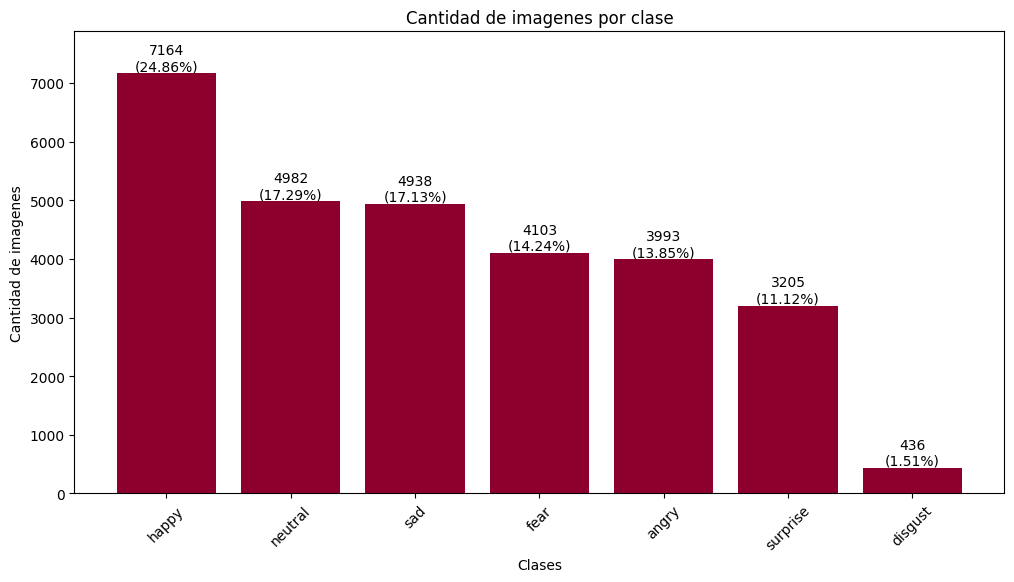

In [29]:
# Get class indices and their respective counts from the training generator
class_indices = train_generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

# Iterate through the generator to count the number of samples per class
for i in range(len(train_generator)):
    _, labels = next(train_generator)
    for label in labels:
        class_name = list(class_indices.keys())[list(class_indices.values()).index(np.argmax(label))]
        class_counts[class_name] += 1

# Sort class_counts by values (from tallest to shortest)
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Calculate total samples
total_samples = sum(sorted_class_counts.values())

# Plotting the bar graph
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), color='#8d002e')

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_samples) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}\n({percentage:.2f}%)', ha='center', va='bottom')

# Adjust y-axis limit to add space at the top
plt.ylim(0, max(class_counts.values()) * 1.1)

plt.xlabel('Clases')
plt.ylabel('Cantidad de imagenes')
plt.title('Cantidad de imagenes por clase')
plt.xticks(rotation=45)
plt.show()

#### Definición de la CNN

In [21]:
# Definir la arquitectura del modelo CNN ajustada para imágenes en blanco y negro
# Las redes neuronales convolucionales (CNN) son particularmente efectivas para el reconocimiento de imágenes debido a su capacidad para captar características espaciales y patrones en los datos de entrada.

model = Sequential([
    # Primera capa convolucional con 32 filtros de tamaño 3x3, función de activación ReLU y una forma de entrada de 64x64x1 (imágenes en blanco y negro)
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),  # Nota: El número de canales es 1 para escala de grises
    BatchNormalization(), # (Añadido en la segunda prueba)
    # Aplicación de Max Pooling con una ventana de 2x2 para reducir la dimensionalidad y retener las características más importantes
    MaxPooling2D(pool_size=(2, 2)),

    # Segunda capa convolucional con 64 filtros de tamaño 3x3 y función de activación ReLU
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(), # (Añadido en la segunda prueba)
    # Aplicación de Max Pooling con una ventana de 2x2 para reducir aún más la dimensionalidad
    MaxPooling2D(pool_size=(2, 2)),

    # Tercera capa convolucional con 128 filtros de tamaño 3x3 y función de activación ReLU
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(), # (Añadido en la segunda prueba)
    # Aplicación de Max Pooling con una ventana de 2x2 para reducir nuevamente la dimensionalidad
    MaxPooling2D(pool_size=(2, 2)),

    # (Nueva capa añadida en la segunda prueba)
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),

    # Capa de Flattening para convertir la matriz resultante de la última capa de pooling en un vector
    Flatten(),

    # Capa densa totalmente conectada con 128 neuronas y función de activación ReLU
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)), # Antes: (Dense(256, activation='relu'),)

    # Capa de Dropout con una tasa de 0.5 para prevenir el sobreajuste durante el entrenamiento
    Dropout(0.5),
    
    # Capa de salida con 7 neuronas (una por cada clase) y función de activación softmax para obtener probabilidades de clasificación
    Dense(7, activation='softmax')  # Suponiendo 7 clases: angry, disgust, fear, happy, neutral, sad, surprise
])


#### Entrenamiento

In [22]:
# Compilación

# Compilar el modelo
# La compilación del modelo es un paso necesario antes de entrenarlo. Aquí se especifican el optimizador, 
# la función de pérdida y las métricas que se utilizarán para evaluar el rendimiento del modelo durante el entrenamiento.

# Parámetro optimizer
# Se ha elegido el optimizador Adam (Adaptive Moment Estimation) porque combina las ventajas de los optimizadores 
# AdaGrad y RMSProp. Adam adapta la tasa de aprendizaje para cada parámetro del modelo, lo que puede conducir a una 
# convergencia más rápida y eficiente. Es conocido por funcionar bien en una amplia gama de problemas de aprendizaje profundo.

# Parámetro learning_rate
# La tasa de aprendizaje se ha fijado en 0.001. Este valor es un buen punto de partida para muchos problemas. 
# Un valor más alto podría hacer que el modelo converja demasiado rápido a un mínimo local, mientras que un valor 
# más bajo podría hacer que el entrenamiento sea innecesariamente lento. Ajustar la tasa de aprendizaje es crucial para 
# el rendimiento del modelo.

# Parámetro loss
# La función de pérdida utilizada es 'categorical_crossentropy'. Esta es la elección estándar para problemas de 
# clasificación multiclase, donde las clases son mutuamente excluyentes. En este caso, estamos clasificando imágenes 
# en una de las 7 categorías de expresiones faciales (angry, disgust, fear, happy, neutral, sad, surprise). 
# La 'categorical_crossentropy' mide la diferencia entre la distribución de las clases verdaderas y las predichas por el modelo.

# Parámetro metrics
# La métrica utilizada es 'accuracy'. La precisión es una métrica intuitiva y fácil de interpretar que mide 
# la fracción de predicciones correctas. Es especialmente útil para evaluar el rendimiento de modelos de clasificación.

# Antes: model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [26]:
# Entrenar el modelo y plottear resultados
class EpochHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epochs = []
        self.accuracy = []
        self.loss = []
        self.val_accuracy = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.accuracy.append(logs.get('accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        self.val_loss.append(logs.get('val_loss'))

# Initialize the custom callback
epoch_history = EpochHistory()


# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=80,  # Ajusta el número de épocas según sea necesario
    callbacks=[epoch_history]
)

# Guardar el modelo
model.save('Riley_12.h5')


Epoch 1/80


900/900 [==============================] - 129s 129ms/step - loss: 2.6123 - accuracy: 0.1985 - val_loss: 2.2073 - val_accuracy: 0.2491
Epoch 2/80
900/900 [==============================] - 123s 137ms/step - loss: 2.2956 - accuracy: 0.2212 - val_loss: 2.1665 - val_accuracy: 0.2547
Epoch 3/80
900/900 [==============================] - 132s 147ms/step - loss: 2.2342 - accuracy: 0.2306 - val_loss: 2.1538 - val_accuracy: 0.2614
Epoch 4/80
900/900 [==============================] - 134s 149ms/step - loss: 2.1909 - accuracy: 0.2348 - val_loss: 2.0936 - val_accuracy: 0.2920
Epoch 5/80
900/900 [==============================] - 132s 146ms/step - loss: 2.1614 - accuracy: 0.2449 - val_loss: 2.0800 - val_accuracy: 0.2716
Epoch 6/80
900/900 [==============================] - 128s 142ms/step - loss: 2.1320 - accuracy: 0.2583 - val_loss: 2.0471 - val_accuracy: 0.3119
Epoch 7/80
900/900 [==============================] - 123s 137ms/step - loss: 2.0957 - accuracy: 0.2672 - val_loss: 2.1105

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


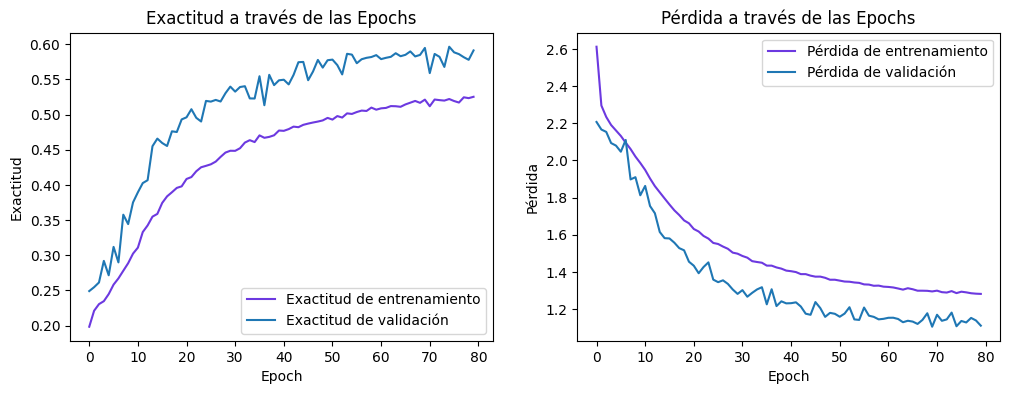

In [27]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch_history.epochs, epoch_history.accuracy, label='Exactitud de entrenamiento', color='#6c39e0')
plt.plot(epoch_history.epochs, epoch_history.val_accuracy, label='Exactitud de validación')
plt.xlabel('Epoch')
plt.ylabel('Exactitud')
plt.legend()
plt.title('Exactitud a través de las Epochs')

plt.subplot(1, 2, 2)
plt.plot(epoch_history.epochs, epoch_history.loss, label='Pérdida de entrenamiento', color='#6c39e0')
plt.plot(epoch_history.epochs, epoch_history.val_loss, label='Pérdida de validación')
plt.xlabel('Epoch')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida a través de las Epochs')

plt.show()